# Experiment 3A. Analysis of how blinks and sound influence perceptual stability of illusory rotation

In [3]:
rm(list=ls())

In [22]:
library(ggplot2)
library(dplyr)
library(BayesFactor)
library(lme4)
library(IRdisplay)

## 1. Importing events from csv-file, converted from original EDFs

In [5]:
all.edf.files <- list.files(path= 'Experiment 3', pattern= 'edf[.]csv$')
events <- data.frame() # complete copy
all.events <- data.frame() # no duplicate percept events (i.e., same percept reported before and after the blink)
for(current.filename in all.edf.files){
    # figuring out the experimental condition: response to the sound was either to blink or to ignore sound
    condition <- ifelse(grepl('blink', current.filename), 'blink', 'ignore sound')
    re.ID <- regexpr('[[:alpha:]]{3}[[:digit:]]{2,4}[[:alpha:]]', current.filename)
    ID<- regmatches(current.filename, re.ID)
        
    # loading current observer
    current.observer <- read.csv2(normalizePath(paste("Experiment 3", current.filename, sep='/')))
    
    # adding ID and condition
    current.observer$Observer <- ID
    current.observer$Condition <- condition
    
    # storing ALL events in the data frame
    all.events <- rbind(all.events, current.observer)
    
    # removing duplicate percepts, i.e. a participant reporting same percept again after the blink
    i.duplicates <- c()
    for(current.block in unique(current.observer$Block)){
        current.percept <- 100 # percept code that is definitely different from anything being reported
        for(i.row in which(current.observer$Block==current.block)){
            if (current.observer$Event[i.row]=='percept'){
                if (current.percept == current.observer$Value[i.row]){
                    i.duplicates <- c(i.duplicates, i.row)
                }
                current.percept <- current.observer$Value[i.row]
            }
        }
    }
    if (length(i.duplicates)>0){
        current.observer <- current.observer[-i.duplicates, ]
    }
    
    # storing the cleaned-up version in the main table
    events <- rbind(events, current.observer)
}


## 2. Computing whether observers report a switch shortly after the event.
Given the variable nature of events and their possible complete absence, here are the rules:
* Baseline (no sound or blink during the entire trial): switch reported between 0.1 and 0.4 relative location, as for Experiments 1 and 2
* Sound (but no blink): switch reported between 0.2 and 0.8 seconds after the sound onset
* Prompted blink: switch reported between 0.2 and 0.8 second after eyes were opened
* Spontaneous blink: switch reported between 0.2 and 0.8 second after eyes were opened (first blink only, if multiple are present)

#### First, marking out trials as `Baseline`, `Sound`, `Prompted blink`, and `Spontaneous blink`

In [6]:
classify.trial <- function(event.time, event.type, event.value, block.condition){
    had.sound <- sum(event.type=='sound')
    had.blink <- sum(event.type=='blink')
    
    if (had.blink>1){
        return('Multiple blinks')
    }
    
    if (!had.sound & !had.blink){
        # neither sound nor blink were present
        return('Baseline')
    }
    else{
        if (had.sound){
            if (had.blink){
                if (block.condition=='blink'){
                    return('Prompted blink')                        
                }
                else {
                    return('Spontaneous blink')
                }
            }
            else{
                return('Sound')
            }
        }
        else{
            return('Spontaneous blink')
        }
    }
}
trial <- events %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::summarize(trial.type= classify.trial(Time, Event, Value, Condition[1]))

# merging the info back into the events table
trial.events <- merge(events, trial, by= c('Observer', 'Condition', 'Block', 'Trial')) %>% 
    dplyr::arrange(Observer, Condition, Block, Trial)

#### Count trials with multiple blinks that we will exclude from the analysis

In [7]:
bad.fraction <- trial %>%
    dplyr::group_by(Observer, Condition) %>%
    dplyr::summarize(bad= 100*sum(trial.type=='Multiple blinks')/n())

condition.fraction <- bad.fraction %>%
    dplyr::group_by(Condition) %>%
    dplyr::summarize(mean.bad= mean(bad),
                     sd.bad= sd(bad))

condition.fraction

Condition,mean.bad,sd.bad
blink,6.833333,7.25000
ignore sound,5.333333,11.40175


## 3. Probabiltiy of the switch for various trial types
__Figure 4A__ in the manuscript.

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-5.930887,-1.180331,5.965444,-11.93089,NA,NA,NA
lm.trial.type,6,-48.523860,-39.022746,30.261930,-60.52386,48.59297,3,1.592478e-10


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: P.switch ~ trial.type + (1 | Observer)
   Data: percepts.per.trial.type

REML criterion at convergence: -41.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5031 -0.2405 -0.1161  0.3509  2.4319 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.000513 0.02265 
 Residual             0.011779 0.10853 
Number of obs: 36, groups:  Observer, 9

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)                  0.01336    0.03696 31.83000   0.361    0.720    
trial.typePrompted blink     0.42667    0.05116 24.00000   8.340  1.5e-08 ***
trial.typeSound              0.04570    0.05116 24.00000   0.893    0.381    
trial.typeSpontaneous blink  0.01758    0.05116 24.00000   0.344    0.734    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed E

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.01335757,0.03695600,31.83369,0.3614453,7.201546e-01,0.06393075
0.42666720,0.05116135,24.00003,8.3396395,1.500082e-08,0.86223622
0.04569887,0.05116135,24.00003,0.8932303,3.806035e-01,0.17937258
0.01758379,0.05116135,24.00003,0.3436928,7.340702e-01,0.06998394


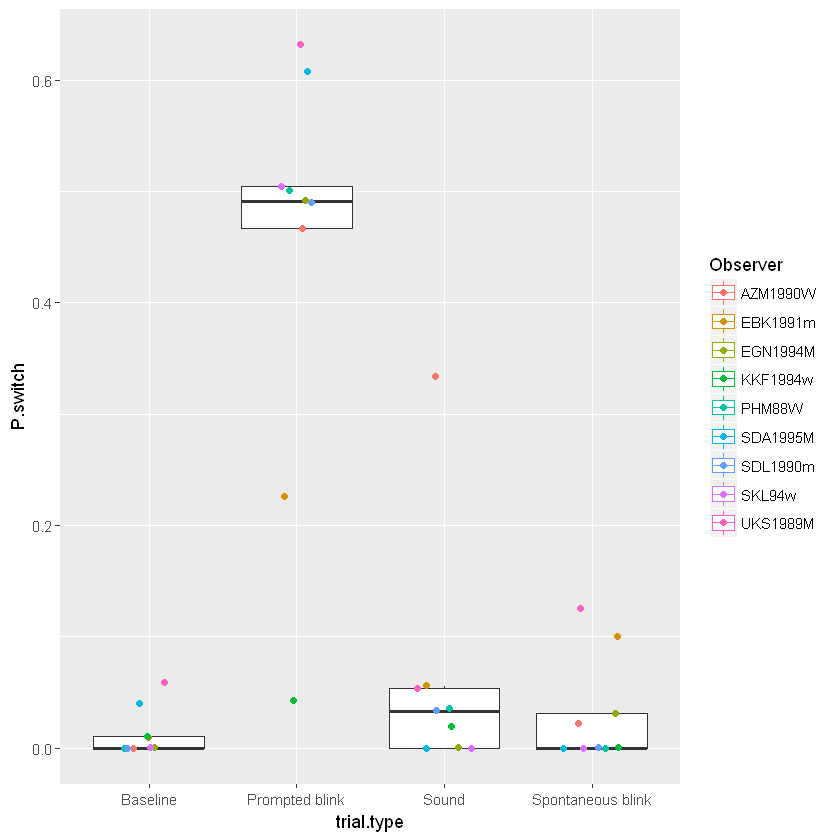

In [8]:
## Next, computing critical time window for the switch
compute.critical.time <- function(event.time, event.type, event.value, trial.type){
    if (trial.type %in% c('Multiple Prompted blinks', 'Multiple Spontaneous blinks')){
        iBlink <- which(event.type=='blink')
        iBlink <- iBlink[length(iBlink)]
        return (event.time[iBlink] +  as.numeric(as.character(event.value[iBlink])) + 200) # first blink onset + first blink duration + 200 ms
    }
    else if (trial.type == 'Prompted blink'){
        iBlink <- which(event.type=='blink')
        iBlink <- iBlink[length(iBlink)]
        return (event.time[iBlink] +  as.numeric(as.character(event.value[iBlink])) + 200) # blink onset + blink duration + 200 ms
    }
    else if (trial.type == 'Spontaneous blink'){
        iBlink <- which(event.type=='blink')
        iBlink <- iBlink[length(iBlink)]
#         return (event.time[iBlink] - 600)
        return (event.time[iBlink] +  as.numeric(as.character(event.value[iBlink])) + 200) # blink onset + blink duration + 200 ms
    }
    else if (trial.type == 'Sound') {
        iSound <- which(event.type=='sound')
        return(event.time[iSound] + 200) # sound onset + 200
    }
    else {
        # Baseline
        return(event.time[1] + 2200) # trial start + half-trial-duration (2000) + 200 ms
    }
}

trial.critical.time <- trial.events %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::mutate(start.time= compute.critical.time(Time, Event, Value, trial.type[1]),
                  end.time= start.time + 600)
    

# # dropping multple blink trials
trial.critical.time <- trial.critical.time[trial.critical.time$trial.type != 'Multiple blinks', ]

## Finally, counting number of percepts reported during the critical time window per trial

count.percepts <- function(event.time, event.type, start.time, end.time){
    if (is.finite(start.time)){
        return(sum(event.type=='percept' & event.time>= start.time & event.time<= end.time))
    }
    else {
        return(NA)
    }
}
percepts.per.trial <- trial.critical.time %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::mutate(percepts.count= count.percepts(Time, Event, start.time[1], end.time[1])) %>%
    dplyr::summarize(percepts.count= percepts.count[1], trial.type= trial.type[1])

## Computing number of percepts reported after the events

percepts.per.trial.type <- percepts.per.trial %>%
    dplyr::group_by(Observer, trial.type) %>%
    dplyr::summarise(P.switch= mean(percepts.count>0))

trial.type.plot <- ggplot(data= percepts.per.trial.type, aes(x= trial.type, y= P.switch, color= Observer, group= trial.type)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(width= 0.2)
#     theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(trial.type.plot)
ggsave(file="Generated figures/Experiment 3 - group averages.pdf", plot= trial.type.plot, width= 12, height= 8, units = 'cm')

# computing significance of the trial type
lm.null <- lme4::lmer(P.switch ~ 1 + (1|Observer), data= percepts.per.trial.type, REML = FALSE)
lm.trial.type <- update(lm.null, .~. + trial.type)
anova(lm.null, lm.trial.type)

# more specifically, comparing everything to the Baseline
compare.to.baseline <- lmerTest::lmer(P.switch ~ trial.type+(1|Observer), percepts.per.trial.type)
summary(compare.to.baseline)

rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

coefficients.only <- data.frame(summary(compare.to.baseline)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


## 4. Same as above, but we are counting the perceptual reports BEFORE the spontaneous blink (not after)

The _Spontaneous blinks_ condition is __Figure 1B__ in the manuscript.

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,-68.62728,-63.87672,37.31364,-74.62728,NA,NA,NA
lm.trial.type,6,-76.80719,-67.30608,44.40360,-88.80719,14.17991,3,0.002670212


Linear mixed model fit by REML t-tests use Satterthwaite approximations to
  degrees of freedom [lmerMod]
Formula: P.switch ~ trial.type + (1 | Observer)
   Data: percepts.per.trial.type

REML criterion at convergence: -66.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1104 -0.6144 -0.1795  0.3053  3.1501 

Random effects:
 Groups   Name        Variance Std.Dev.
 Observer (Intercept) 0.001437 0.03790 
 Residual             0.004558 0.06751 
Number of obs: 36, groups:  Observer, 9

Fixed effects:
                            Estimate Std. Error       df t value Pr(>|t|)   
(Intercept)                  0.01336    0.02581 27.29600   0.518  0.60893   
trial.typePrompted blink     0.09672    0.03183 24.00000   3.039  0.00566 **
trial.typeSound              0.04570    0.03183 24.00000   1.436  0.16393   
trial.typeSpontaneous blink  0.11784    0.03183 24.00000   3.703  0.00111 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effect

Estimate,Std.Error,df,t.value,p.value,R.sqr
0.01335757,0.02580826,27.29635,0.5175696,0.608927990,0.09858159
0.09671703,0.03182551,24.00009,3.0389782,0.005655771,0.52714080
0.04569887,0.03182551,24.00009,1.4359193,0.163932172,0.28127205
0.11784256,0.03182551,24.00009,3.7027704,0.001112566,0.60296914


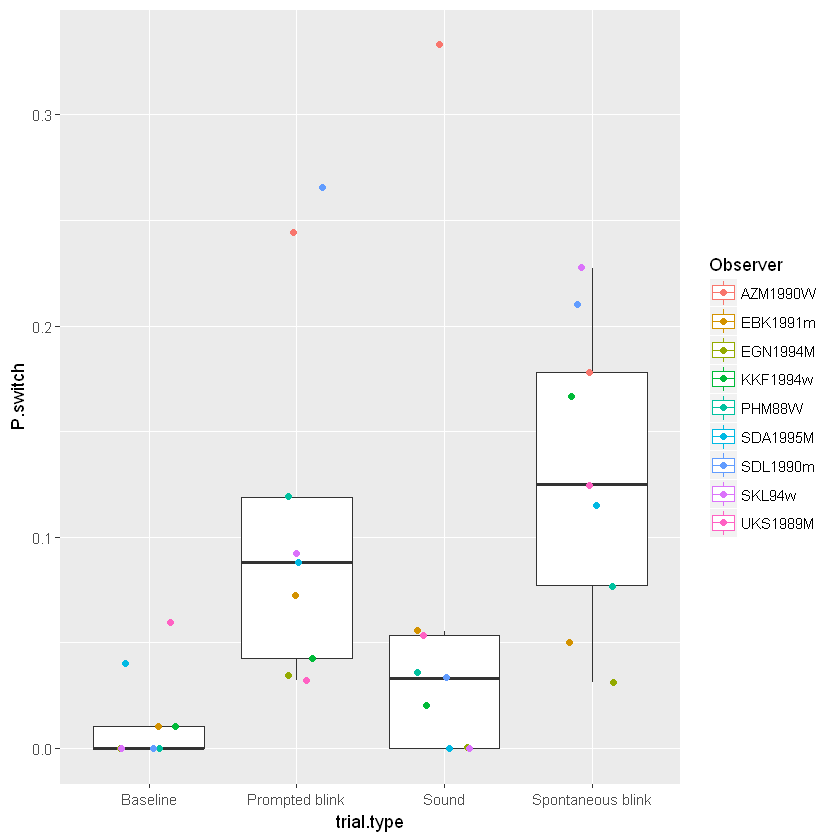

In [9]:
## Next, computing critical time window for the switch
compute.critical.time <- function(event.time, event.type, event.value, trial.type){
    if (trial.type %in% c('Multiple Prompted blinks', 'Multiple Spontaneous blinks')){
        iBlink <- which(event.type=='blink')
        iBlink <- iBlink[length(iBlink)]
        return (event.time[iBlink] +  as.numeric(as.character(event.value[iBlink])) + 200) # first blink onset + first blink duration + 200 ms
    }
    else if (trial.type == 'Prompted blink'){
        iBlink <- which(event.type=='blink')
        iBlink <- iBlink[length(iBlink)]
#         return (event.time[iBlink] +  as.numeric(as.character(event.value[iBlink])) + 200) # blink onset + blink duration + 200 ms
        
        # ----------------------------------------------------------------------
        return (event.time[iBlink] - 600) # THIS IS THE PART WHICH IS DIFFERENT
        # ----------------------------------------------------------------------        
    }
    else if (trial.type == 'Spontaneous blink'){
        iBlink <- which(event.type=='blink')
        iBlink <- iBlink[length(iBlink)]
        
        # ----------------------------------------------------------------------
        return (event.time[iBlink] - 600) # THIS IS THE PART WHICH IS DIFFERENT
        # ----------------------------------------------------------------------
        
    }
    else if (trial.type == 'Sound') {
        iSound <- which(event.type=='sound')
        return(event.time[iSound] + 200) # sound onset + 200
    }
    else {
        # Baseline
        return(event.time[1] + 2200) # trial start + half-trial-duration (2000) + 200 ms
    }
}

trial.critical.time <- trial.events %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::mutate(start.time= compute.critical.time(Time, Event, Value, trial.type[1]),
                  end.time= start.time + 600)
    

# # dropping multple blink trials
trial.critical.time <- trial.critical.time[trial.critical.time$trial.type != 'Multiple blinks', ]

## Finally, counting number of percepts reported during the critical time window per trial

count.percepts <- function(event.time, event.type, start.time, end.time){
    if (is.finite(start.time)){
        return(sum(event.type=='percept' & event.time>= start.time & event.time<= end.time))
    }
    else {
        return(NA)
    }
}
percepts.per.trial <- trial.critical.time %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::mutate(percepts.count= count.percepts(Time, Event, start.time[1], end.time[1])) %>%
    dplyr::summarize(percepts.count= percepts.count[1], trial.type= trial.type[1])

## Computing number of percepts reported after the events

percepts.per.trial.type <- percepts.per.trial %>%
    dplyr::group_by(Observer, trial.type) %>%
    dplyr::summarise(P.switch= mean(percepts.count>0))

trial.type.plot <- ggplot(data= percepts.per.trial.type, aes(x= trial.type, y= P.switch, color= Observer, group= trial.type)) + 
    geom_boxplot(outlier.shape = NA) + 
    geom_jitter(width= 0.2)
#     theme(axis.text.x = element_text(angle = 90, hjust = 1))
print(trial.type.plot)
ggsave(file="Generated figures/Experiment 3 - group averages 2.pdf", plot= trial.type.plot, width= 12, height= 8, units = 'cm')

# computing significance of the trial type
lm.null <- lme4::lmer(P.switch ~ 1 + (1|Observer), data= percepts.per.trial.type, REML = FALSE)
lm.trial.type <- update(lm.null, .~. + trial.type)
anova(lm.null, lm.trial.type)

# more specifically, comparing everything to the Baseline
compare.to.baseline <- lmerTest::lmer(P.switch ~ trial.type+(1|Observer), percepts.per.trial.type)
summary(compare.to.baseline)

rcontrast<-function(t, df) {
    return (sqrt(t^2/(t^2 + df)))
}

coefficients.only <- data.frame(summary(compare.to.baseline)$coefficients)
colnames(coefficients.only) <- c('Estimate', 'Std.Error', 'df', 't.value', 'p.value')
dplyr::mutate(coefficients.only, R.sqr= rcontrast(t.value, df))


## 5. Computing proportion of trials for each condition

In [10]:
trial.count <- percepts.per.trial %>%
    dplyr::group_by(Observer) %>%
    dplyr::mutate(total.trials= n()) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Observer, trial.type) %>%
    dplyr::summarize(proportion= n()/total.trials[1]) %>%
    dplyr::group_by(trial.type) %>%
    dplyr::summarize(mean= mean(proportion)*100, std= sd(proportion)*100)
trial.count

trial.type,mean,std
Baseline,30.53515,6.045056
Prompted blink,41.10256,1.941926
Sound,16.18725,6.091254
Spontaneous blink,12.17504,11.161588


## 6. Examining effect of the prompted blinks duration

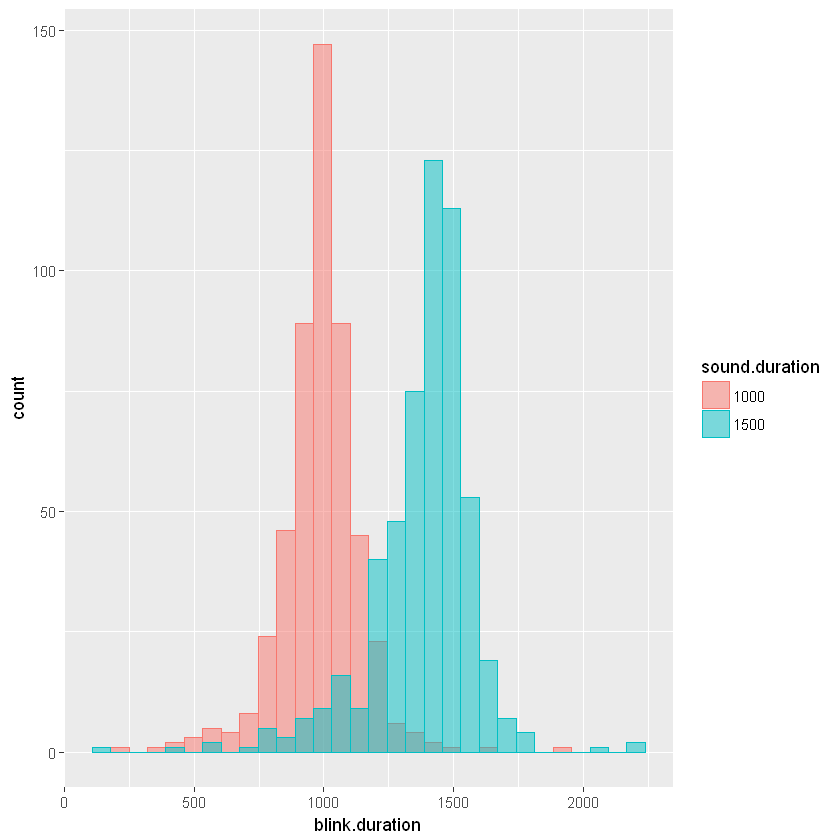

In [11]:
prompted.blinks.percepts <- percepts.per.trial %>% dplyr::filter(trial.type=='Prompted blink')

compute.prompted.blink.duration <- function(event.type, event.value){
    iBlink <- which(event.type=='blink')
    return (as.numeric(as.character(event.value[iBlink])))
}

compute.sound.duration <- function(event.type, event.value){
    iSound <- which(event.type=='sound')
    return (as.numeric(as.character(event.value[iSound])))
}

prompted.blinks.duration <- trial.critical.time %>%
    dplyr::filter(trial.type=='Prompted blink') %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::summarize(blink.duration= compute.prompted.blink.duration(Event, Value),
                     sound.duration = compute.sound.duration(Event, Value))
prompted.blinks.percepts <- merge(prompted.blinks.percepts, prompted.blinks.duration, c('Observer', 'Condition', 'Block', 'Trial'))
prompted.blinks.percepts$sound.duration <- as.factor(prompted.blinks.percepts$sound.duration)
prompted.blinks.percepts$switch <- prompted.blinks.percepts$percepts.count>0

prompted.blink.duration.plot <- ggplot(data= prompted.blinks.percepts, aes(x= blink.duration, color= sound.duration, fill= sound.duration)) + 
    geom_histogram(position= 'identity', alpha= 0.5, bins= 30)
print(prompted.blink.duration.plot)

### Looking whether prompted blink duration significantly alter the probability of the switch

In [12]:
# computing P.switch per duration
percept.per.blink.duration <- prompted.blinks.percepts %>%
    dplyr::group_by(Observer, blink.duration) %>%
    dplyr::summarize(P.switch= mean(percepts.count>0))

lm.null <- lme4::lmer(P.switch ~ 1 + (1|Observer), data= percept.per.blink.duration, REML = FALSE)
lm.duration <- update(lm.null, .~. + blink.duration)
anova(lm.null, lm.duration)

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
lm.null,3,121.1615,135.0456,-57.58074,115.16147,NA,NA,NA
lm.duration,4,104.3494,122.8616,-48.17472,96.34944,18.81203,1,1.44254e-05


## 7. Looking at the distribution of blink durations for prompted vs. continuous

Computing how many frames are necessary for the object to move to a spatially non-overlapping location on the screen

In [13]:
# experimental settings, as described in the methods
screen.width.pix <- 1920
trajectory.limits <- screen.width.pix * c(0.2, 0.8)
sfm.width <- 150
screen.FPS <- 60
trial.duration <- 4

shift.per.frame <- diff(trajectory.limits)/(trial.duration * screen.FPS)

complete.shift.ms <- 1000*(sfm.width/shift.per.frame)/screen.FPS
half.shift.ms <- complete.shift.ms/2

### Looking at the distribution of blink durations
This is the __Figure 4C__ in the manuscript.

Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."Warning message:
"Transformation introduced infinite values in continuous x-axis"Warning message:
"Removed 1 rows containing non-finite values (stat_bin)."

trial.type,log.mean,log.std,mean,lower.ci,upper.ci,less.than.half.shift,less.than.full.shift
Prompted blink,7.056316,0.2499456,1160.1632,903.58519,1489.598,0.192123,0.6724304
Spontaneous blink,4.630081,0.7448221,102.5224,48.67956,215.919,93.055556,97.2222222


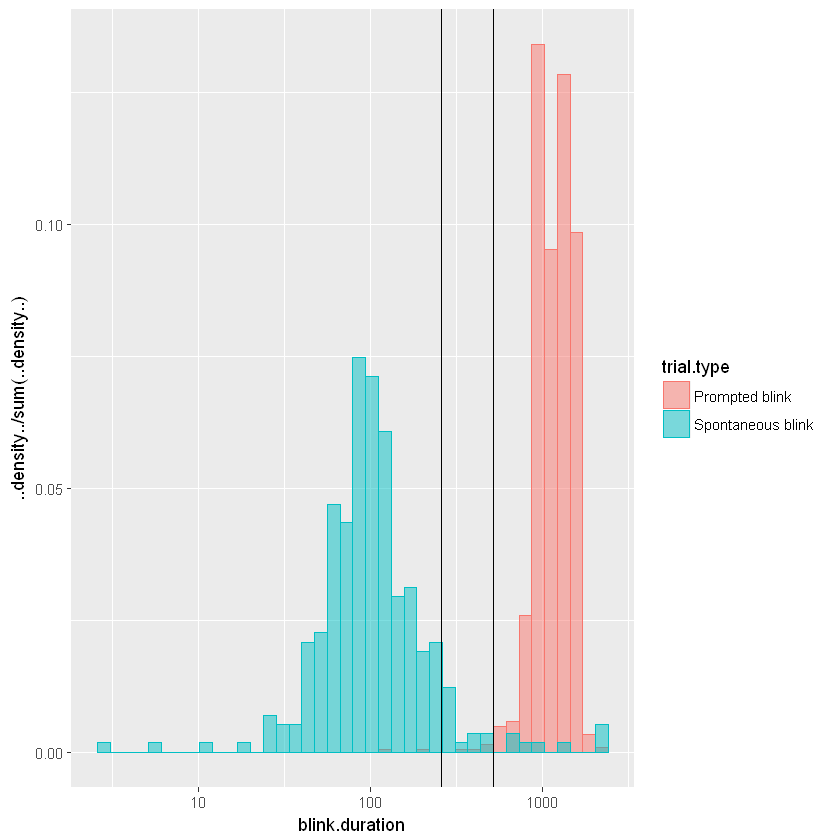

In [14]:
compute.blink.duration <- function(event.type, event.value){
    iBlink <- which(event.type=='blink')
    return (sum(as.numeric(as.character(event.value[iBlink]))))
}


blinks.percepts <- percepts.per.trial %>% dplyr::filter(trial.type %in% c('Prompted blink', 'Spontaneous blink', 'Multiple blinks'))

blinks.duration <- trial.critical.time %>%
    dplyr::filter(trial.type %in% c('Prompted blink', 'Spontaneous blink', 'Multiple blinks')) %>%
    dplyr::group_by(Observer, Condition, Block, Trial) %>%
    dplyr::summarize(blink.duration= compute.blink.duration(Event, Value),
                     trial.type= trial.type[1])

blinks.percepts <- merge(blinks.percepts, blinks.duration, c('Observer', 'Condition', 'Block', 'Trial', 'trial.type'))
blinks.percepts$switch <- blinks.percepts$percepts.count>0

blink.duration.plot <- ggplot(data= blinks.percepts, aes(x= blink.duration, group= trial.type, fill= trial.type, color= trial.type)) + 
    geom_histogram(aes(y= ..density../sum(..density..)), bins= 40, alpha= 0.5, position="identity")+
#     scale_y_continuous(labels = percent_format()) + 
#     xlim(0, 2500)+
    geom_vline(xintercept = c(half.shift.ms, complete.shift.ms))+
    scale_x_log10()
print(blink.duration.plot)
ggsave(file="Generated figures/Experiment 3 - blink durations.pdf", plot= blink.duration.plot, width= 12, height= 8, units = 'cm')


avg.blink <- blinks.percepts %>%
    dplyr::filter(blink.duration>0) %>%
    dplyr::mutate(log.duration= log(blink.duration)) %>%
    dplyr::group_by(trial.type) %>%
    dplyr::summarise(log.mean= mean(log.duration),
                     log.std= sd(log.duration),
                     mean= exp(log.mean),
                     lower.ci= exp(log.mean-log.std),
                     upper.ci= exp(log.mean+log.std), 
                     less.than.half.shift= 100*mean(blink.duration < half.shift.ms),
                     less.than.full.shift= 100*mean(blink.duration < complete.shift.ms))
avg.blink